In [1]:
import copy

import cv2
from matplotlib import pyplot as plt
from object_data_csv import create_object_df, prepare_object_dict, add_to_csv, create_csv

##################################### Vision Imports ###########################################
import numpy as np
import os
import vision_tools as vt
from vision_tools import normclean2cv2
import kinect_vision as kv
from kinect_vision import PATH_TO_KINECT_IMAGES_DIR
from image_processing import run_calibration, run_calibration_rgb
from image_processing import run_image_processing_v2_depth, run_image_processing_v2_rgb
import grasping_points as gp

from tableObject_class import TableObject, match_rgb_with_depth, match_rgb_with_depth_v2
object_ipt_dict = {'cd':      [1,'rgb'],
                   'book':    [2,'rgb'],
                   'eraser':  [3,'rgb'],
                   'measure': [4,'depth'],
                   'box':     [5,'rgb'],
                   'mug':     [6,'depth'],
                   'torch':   [7,'depth'],
                   'tape':    [8,'depth'],
                   'banana':  [9,'depth'],
                   'ball':    [10,'depth']}


##################### Vision Initialise #####################################
directory = PATH_TO_KINECT_IMAGES_DIR

cali = kv.load_npz_as_array("im_array_cal_FINAL", directory)
empt = kv.load_npz_as_array("im_array_empty_FINAL", directory)

empt_all = kv.prepare_im_array(empt)
cali_all = kv.prepare_im_array(cali)

depth_cali = run_calibration(empt_all, cali_all, adjust=False)
rgb_cali = run_calibration_rgb(empt_all, cali_all, depth_cali, adjust=False)

{'radius': [8, 16], 'thresh': [85, 100]}
33
All Calibration points found
{'radius': [5, 8], 'thresh': [85, 220]}
10
All Calibration points found
(173, 200)


Ready?: yes
Depth Done
(173, 200)
[1]
Making depth List ...
RGB data not considered
An exception of type AttributeError occurred. Arguments:
("'TableObject' object has no attribute 'rgb_box'",)
Making rgb object list...
Depth data not implemented
An exception of type AttributeError occurred. Arguments:
("'TableObject' object has no attribute 'box'",)
item
Length of depth and obj lists: 1 1
Matched based on Contour Overlap
1
Index([u'ball', u'mug'], dtype='object', name=u'name')
NAME:  ball
item


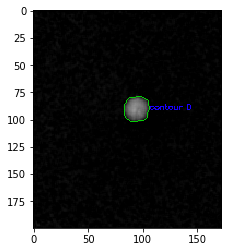

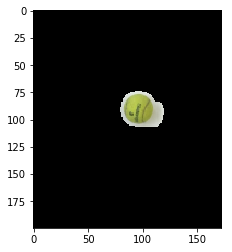

        OBJECT IS:  ball
done
[[0.0, 0.0], [9.5, 200.0], [173.5, 193.0]]
OBJECT TO BE PICKED BY GRASPING
PERPERP [ 9.14457703  4.1807251 ]
CURRENT_LINE:  [9.1445770263671875, 4.18072509765625]
FIRST_NODE:  [ 104.   95.]
POSSIBLE_SECOND_NODE AND GRASP_CENTRE:  [[87.180327868852459, 80.983606557377044]] [array([ 95.59016393,  87.99180328])]


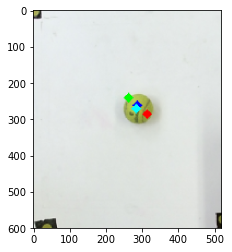

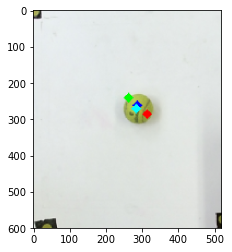

~~~~~~~~~~~~~~ OBJECT ATTRIBUTES ~~~~~~~~~~~~~~~
GRASPING
Height:        (0.35621148, 0.32791349, 0.60212326, 0.0)
RGB Aspect:    0.820512820513
Circularness:  0.845949270118


In [2]:
while(1):
    capture_check = raw_input("Ready?: ")
    if capture_check == "yes":
        test = kv.capture_frames()
        test_all = kv.prepare_im_array(test)
        break

######## Process Test Image and Retrieve Depth and Contour Information from Depth and RGB Data ##########

rgb, depth, ir = test_all


normclean, sorted_family = run_image_processing_v2_depth(test_all, 
                                                         depth_cali, 
                                                         show=False)

rgbnormclean, rgb_family, test_rgbx_img = run_image_processing_v2_rgb(test_all, 
                                                                      rgb_cali, 
                                                                      depth_cali, 
                                                                      show=False)

######## Clean the images and convert them so that they are cv2 compatible ############

depth_normclean = normclean2cv2(normclean)
rgb_normclean = normclean2cv2(rgbnormclean)


test_rgb_img = vt.convert2rgb(test_rgbx_img)

cv2.imwrite("test_rgb_img.jpg", test_rgb_img)

####### Create List of Objects and match the rgb and depth data ##########
object_list = match_rgb_with_depth_v2(sorted_family, rgb_family, depth_normclean, test_rgb_img)



#cv2.imwrite("test_rgb_img.jpg", test_rgb_img)
cv2.imwrite("depth_normclean.jpg", depth_normclean)

import object_recognition_tools as ort

excluded_val = ['centre', 'rgb_centre', 'number of children']
extras = ['R','G','B', 'centre_offset']

obj_features_mean, obj_features_std = ort.prepare_obj_features_param(obj_feat_csv = 'object_features.csv', 
                                                                 excluded_val = excluded_val, 
                                                                 extras=extras)

rec_df = ort.prepare_pick_obj_features_param(object_list, excluded_val, extras)
cost_list = ort.create_cost_list(obj_features_mean, obj_features_std, rec_df)
object_list = ort.label_object_list(object_list, cost_list, test_rgb_img, show=True)

for item in object_list.keys():
    if object_list[item].height[0] == 0:
        #if abs(object_list[item].rgb_area - 3*obj_features_mean.rgb_area.book)/obj_features_std.rgb_area.book > 1:
            #print "TOO SMALL/BIG TO BE BOOK"
            #del object_list[item]
        if object_list[item].name != 'cd':
            print "TO BE DELETED: ",item
            del object_list[item]

if len(object_list) == 0:
    "THERE IS NOTHING INSIDE!!!!!!!!!!!"

pick_obj = object_list.values()[0]

print "==========================================="
print "        OBJECT IS: ", pick_obj.name
print "==========================================="

object_df = create_object_df()
create_csv("testing_object_features", object_df)
for item in object_list.keys():
    object_dict = prepare_object_dict(object_list[item], object_df)
    object_df = object_df.append(object_dict, ignore_index=True)

add_to_csv("testing_object_features.csv", object_df)

########### Find Circles for Pix3world transformation ################
circles = depth_cali[4]
cali_circles_init = circles-circles[0][0]
cali_circles=[]
for circ in cali_circles_init[0]:
    cali_circles.append([circ[0]/2, circ[1]/2])

print cali_circles


################ Find the suction or grasping points in pixels ###########
ipt = object_ipt_dict[pick_obj.name][0]

if ipt>5:
    print "OBJECT TO BE PICKED BY GRASPING"
    first_node, node1, node2 = gp.first_grasping_point(pick_obj)
    #
    
    current_line = gp.find_perpendicular_line(node1, node2[0])
    if ipt == 10:
        perp_vect = np.array(first_node-pick_obj.centre)
        print "PERPERP",perp_vect
        current_line = [perp_vect[0], perp_vect[1]]
    possible_pairs = gp.find_possible_cross_pairs(pick_obj, first_node, current_line)
    possible_pairs = gp.remove_duplicates(possible_pairs, node1, node2[0])
    print "CURRENT_LINE: ", current_line
    print "FIRST_NODE: ", first_node
    possible_second_node, possible_grasp_centre = gp.find_second_grasping_point(possible_pairs, 
                                                                                first_node, 
                                                                                pick_obj)
    print "POSSIBLE_SECOND_NODE AND GRASP_CENTRE: ", possible_second_node, possible_grasp_centre
    second_node, grasp_centre = gp.determine_best_grasping_point(possible_second_node, 
                                                                 possible_grasp_centre,
                                                                 first_node)

    if ipt==7:
        first_node, second_node = gp.fix_torch_orientation(pick_obj, rgb_normclean, first_node, second_node)

    imgimg=gp.display_grasping_points(test_rgb_img, first_node, second_node, grasp_centre, pick_obj, show=True)
    cv2.imwrite("testing_imgimg.jpg", imgimg)
    plt.figure("HELLO")
    plt.imshow(imgimg)
    plt.show()
else:
    print "OBJECT TO BE PICKED BY SUCTION"
    if object_ipt_dict[pick_obj.name][1] == 'rgb':
        x_pix = pick_obj.rgb_centre[0]
        y_pix = pick_obj.rgb_centre[1]
    else:
        x_pix = pick_obj.centre[0]
        y_pix = pick_obj.centre[1]

    plt.figure("Circles")
    show_img = copy.copy(test_rgb_img)
    cv2.circle(show_img,(int(x_pix),int(y_pix)),3,(0,0,255),1)
    cv2.circle(show_img,(int(x_pix),int(y_pix)),2,(0,0,255),1)
    plt.imshow(show_img)
    #plt.show()
    cv2.imwrite("test_rgb_img_centre.jpg", show_img)


print "~~~~~~~~~~~~~~ OBJECT ATTRIBUTES ~~~~~~~~~~~~~~~"
if ipt>5:
    print "GRASPING"
else:
    print "SUCTION"
print "Height:       ", pick_obj.height
print "RGB Aspect:   ", pick_obj.rgb_aspect
try:
    print "Circularness: ", pick_obj.circularness
except:
    print "no depth"